In [40]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.metrics import mean_squared_error as MSE
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [41]:
df = pd.read_csv('data_cleaned.csv')

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30110 entries, 0 to 30109
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     30110 non-null  int64  
 1   id             30110 non-null  int64  
 2   date           30110 non-null  object 
 3   price          30110 non-null  float64
 4   bedrooms       30110 non-null  int64  
 5   bathrooms      30110 non-null  float64
 6   sqft_living    30110 non-null  int64  
 7   sqft_lot       30110 non-null  int64  
 8   floors         30110 non-null  float64
 9   waterfront     30110 non-null  object 
 10  greenbelt      30110 non-null  object 
 11  nuisance       30110 non-null  object 
 12  view           30110 non-null  object 
 13  condition      30110 non-null  object 
 14  grade          30110 non-null  object 
 15  heat_source    30110 non-null  object 
 16  sewer_system   30110 non-null  object 
 17  sqft_above     30110 non-null  int64  
 18  sqft_b

In [43]:
X = df[['bedrooms', 'bathrooms','sqft_living']]
y = df['price']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 1337)

training_data = pd.concat([X_train, y_train], axis = 1)
testing_data = pd.concat([X_test, y_test], axis = 1)

dummy_regr = DummyRegressor()
dummy_regr.fit(X_train, y_train)
dummy_regr.predict(X_train)
dummy_regr.predict(X_test)
dummy_regr.score(X_train, y_train)
dummy_regr.score(X_test, y_test)
dummy_train_RMSE = MSE(y_train,dummy_regr.predict(X_train), squared = False)
dummy_test_RMSE = MSE(y_test,dummy_regr.predict(X_test), squared = False)

print()
print(f'Baseline Model Train Score: {dummy_regr.score(X_train, y_train)}')
print(f'Baseline Model Train RMSE: {round(dummy_train_RMSE)}')
print()
print(f'Baseline Model Test Score: {dummy_regr.score(X_test, y_test)}')
print(f'Baseline Model Test RMSE: {round(dummy_test_RMSE)}')


Baseline Model Train Score: 0.0
Baseline Model Train RMSE: 888956.0

Baseline Model Test Score: -1.850120194157867e-06
Baseline Model Test RMSE: 911548.0


In [45]:
most_correlated_feature = 'sqft_living'

In [46]:
from sklearn.linear_model import LinearRegression

base_model = LinearRegression()

In [47]:
splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=1337)

base_scores = cross_validate(
    estimator=base_model,
    X=X_train[[most_correlated_feature]],
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", base_scores["train_score"].mean())
print("Validation score:", base_scores["test_score"].mean())

Train score:      0.37501726498507876
Validation score: 0.3808790945087108


In [48]:
X_train_simple_model = X_train[['sqft_living']]
X_test_simple_model = X_test[['sqft_living']]

splitter = ShuffleSplit(n_splits=3, test_size=0.33, random_state=1337)

simple_model = LinearRegression()
simple_model.fit(X_train_simple_model,y_train)

simple_model_scores = cross_validate(estimator=simple_model, X=df[['sqft_living']], y=df.price, return_train_score=True, cv=splitter)

simple_predict_train = simple_model.predict(X_train_simple_model)
simple_predict_test = simple_model.predict(X_test_simple_model)

simple_train_RMSE = MSE(y_train,simple_predict_train,squared = False)
simple_test_RMSE = MSE(y_test,simple_predict_test, squared = False)

simple_condition_num = sm.OLS(y_train, sm.add_constant(X_train_simple_model)).fit().condition_number

print(f'Simple Model Train score: {simple_model_scores["train_score"].mean()}')
print(f'Simple Model Train RMSE: {round(simple_train_RMSE)}')
print(f'Simple Model Train Condition Number: {simple_condition_num}')
print()
print("Simple Model Test score: ", simple_model_scores["test_score"].mean())
print(f'Simple Model Test RMSE: {round(simple_test_RMSE)}')

Simple Model Train score: 0.37092203381403216
Simple Model Train RMSE: 701522.0
Simple Model Train Condition Number: 5571.691959284813

Simple Model Test score:  0.36878465141230404
Simple Model Test RMSE: 730919.0


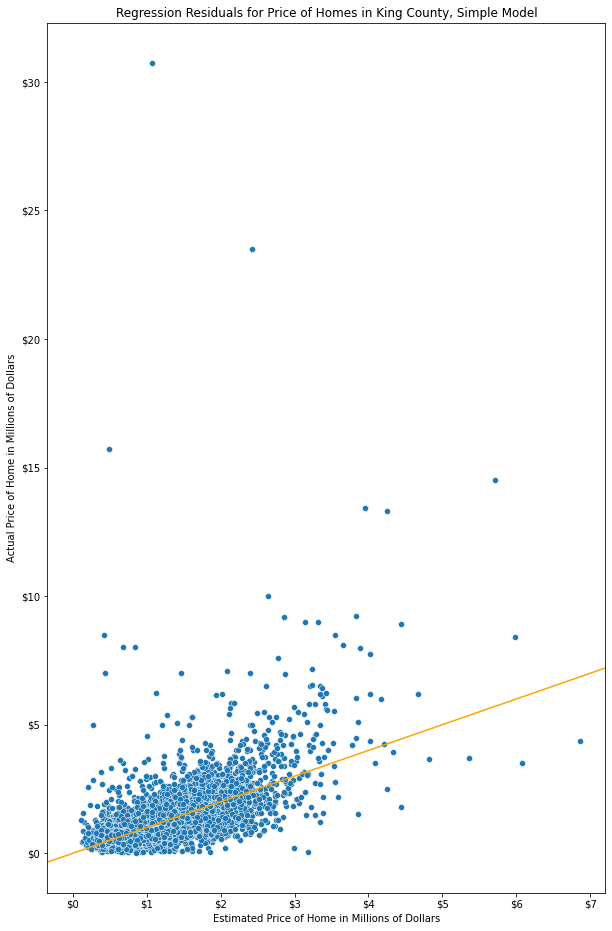

In [49]:
fig, ax = plt.subplots(figsize = (10,16))

sns.scatterplot(x = simple_predict_test, y = y_test, ax=ax)
ax.set_title('Regression Residuals for Price of Homes in King County, Simple Model')
ax.set_xlabel('Estimated Price of Home in Millions of Dollars')
ax.set_ylabel('Actual Price of Home in Millions of Dollars')
ax.ticklabel_format(style='plain') 
millions = ticker.FuncFormatter(lambda x, pos: '${0:g}'.format(x/1000000))
ax.yaxis.set_major_formatter(millions)
ax.xaxis.set_major_formatter(millions)
x,y = [range(0,2500000,500000)],[range(0,2500000,500000)]
plt.axline((0,0),(2500000,2500000), color = 'orange')
plt.show()